In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
train_dir = "../train/"

class GameDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms=None):
    self.root = root
    self.transform = transforms

    self.im_path = os.listdir(self.root)

  def __len__(self):
    return len(self.im_path)

  def __getitem__(self, index):
    image_path = os.path.join(self.root, self.im_path[index])
    label = image_path.split('-')[2]

    # Load image
    img = Image.open(image_path)
    img = img.convert('RGB')

    if self.transform:
      img = self.transform(img)
    else:
      # Convert to tensor
      img = torch.from_numpy(np.array(img))
    
    rating_norm = float(label.split('.')[0]) / 100.0

    return (img, torch.tensor(rating_norm, dtype=torch.float32))

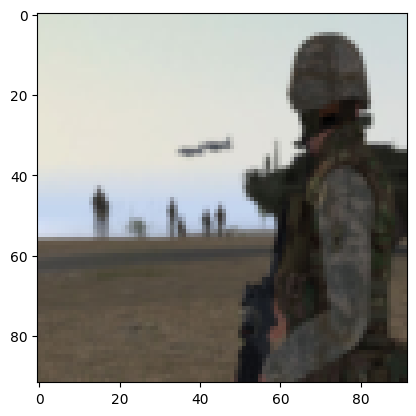

In [3]:
from torch.utils.data import DataLoader

train_transforms = transforms.Compose(
  [
    transforms.Resize(size=(92, 92)),
    transforms.ToTensor(),
  ]
)

dataset = GameDataset(root=train_dir, transforms=train_transforms)

# Split dataset
train_len = int(len(dataset) * 0.8)
test_len = len(dataset) - train_len
train_data_custom, test_data_custom = torch.utils.data.random_split(dataset, [train_len, test_len])

# Show image
img, label = train_data_custom[0]
img_permute = img.permute(1, 2, 0)

plt.imshow(img_permute)
plt.show()

In [10]:
train_dataloader = torch.utils.data.DataLoader(train_data_custom, batch_size=32, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_data_custom, batch_size=32, shuffle=False, num_workers=0)

In [4]:
from torchvision import models

class ReviewPredictionModel(nn.Module):
    def __init__(self):
        super(ReviewPredictionModel, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 1)  # Output a single value
    
    def forward(self, x):
        return self.model(x)

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

model = ReviewPredictionModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, ratings in train_dataloader:
        images, ratings = images.to(device), ratings.to(device)
        
        optimizer.zero_grad()
        outputs = model(images).squeeze()  # Remove unnecessary dimensions
        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss / len(train_dataloader)}")

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, ratings in test_dataloader:
            images, ratings = images.to(device), ratings.to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, ratings)
            val_loss += loss.item()
    
    print(f"Validation Loss: {val_loss / len(test_dataloader)}")

# Save the model
torch.save(model.state_dict(), 'model_ce.pt')

Epoch 1/20, Train Loss: 96.92416758709643
Validation Loss: 94.98703947521392
Epoch 2/20, Train Loss: 95.90844221000212
Validation Loss: 94.35816955566406
Epoch 3/20, Train Loss: 95.08155179310994
Validation Loss: 93.91416931152344
Epoch 4/20, Train Loss: 94.58741815406155
Validation Loss: 93.67471531459263
Epoch 5/20, Train Loss: 94.3304265952972
Validation Loss: 93.55059269496373
Epoch 6/20, Train Loss: 94.23001659347351
Validation Loss: 93.50838216145833
Epoch 7/20, Train Loss: 94.17922569182981
Validation Loss: 93.51879337855748
Epoch 8/20, Train Loss: 94.16243109645613
Validation Loss: 93.48482041131882
Epoch 9/20, Train Loss: 94.14256341773343
Validation Loss: 93.48533848353794
Epoch 10/20, Train Loss: 94.12584327789675
Validation Loss: 93.48271142868768
Epoch 11/20, Train Loss: 94.11345782911921
Validation Loss: 93.51701827276321
Epoch 12/20, Train Loss: 94.10811146196113
Validation Loss: 93.47156016031902
Epoch 13/20, Train Loss: 94.10366848865188
Validation Loss: 93.46873982747

In [12]:

# Path to your test image
images = [
    "../train/2089350-1-94.jpg",
    "../train/2357570-2-40.jpg",
    "../train/2328760-2-63.jpg",
    "cruelty-0-96.jpg",
    "ace-0-87.jpg",
]

# Transform for the test image (same as training)
transform = train_transforms

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
model = ReviewPredictionModel()  # Replace with your model class
model.load_state_dict(torch.load("model.pt", map_location=device, weights_only=True))
model.to(device)
model.eval()

# Load and preprocess the test image
for path in images:
  image = Image.open(path).convert('RGB')
  image = transform(image).unsqueeze(0)  # Add batch dimension
  real_pct = float(path.split('-')[-1].split('.')[0])

  # Perform inference
  with torch.no_grad():
      image = image.to(device)
      predicted_rating = model(image).item()  # Get the predicted rating as a scalar

  # Convert the normalized rating back to percentage
  predicted_percentage = predicted_rating * 100

  print(f"{path} | Predicted: {predicted_percentage:.2f}% | Real: {real_pct:.2f}% | Difference: {abs(predicted_percentage - real_pct):.2f}%")


/Users/spikehd/.venvs/default/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/spikehd/.venvs/default/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


../train/2089350-1-94.jpg | Predicted: 95.58% | Real: 94.00% | Difference: 1.58%
../train/2357570-2-40.jpg | Predicted: 47.85% | Real: 40.00% | Difference: 7.85%
../train/2328760-2-63.jpg | Predicted: 57.21% | Real: 63.00% | Difference: 5.79%
cruelty-0-96.jpg | Predicted: 87.51% | Real: 96.00% | Difference: 8.49%
ace-0-87.jpg | Predicted: 85.53% | Real: 87.00% | Difference: 1.47%
